In [123]:
import networkx as nx
import itertools
from ortools.linear_solver import pywraplp
import time
import random

In [124]:
def eliminacao_de_ciclos(graph, centrais, grau_minimo):
    inicio = time.time()
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    # Variáveis binárias para as arestas
    x = {}
    for u, v in graph.edges():
        # Arestas são armazenadas de forma ordenada (u < v) para evitar problemas de chave
        x[(min(u, v), max(u, v))] = solver.BoolVar(f"x_{min(u, v)}_{max(u, v)}")

    # Função objetivo: minimizar o custo total da árvore geradora
    solver.Minimize(solver.Sum(graph[u][v]['weight'] * x[(min(u, v), max(u, v))] for u, v in graph.edges()))

    # Restrição 1: A soma das arestas entre os vértices centrais deve ser c-1
    solver.Add(solver.Sum(x[(min(u, v), max(u, v))] for u, v in graph.edges() if u in centrais and v in centrais) == len(centrais) - 1)

    # Restrição 2: Eliminar ciclos para os vértices centrais
    for subset in nx.find_cliques(graph.subgraph(centrais)):
        if len(subset) > 1:
            solver.Add(solver.Sum(x[(min(u, v), max(u, v))] for u, v in graph.edges(subset) if (min(u, v), max(u, v)) in x) <= len(subset) - 1)
    
    # Restrição 3: Grau mínimo dos vértices centrais
    for v in centrais:
        solver.Add(solver.Sum(x[(min(u, v), max(u, v))] for u, v in graph.edges(v) if (min(u, v), max(u, v)) in x) >= grau_minimo)
    
    # Definindo tempo limite 30 min
    solver.set_time_limit(1800000)

    # Resolvendo o problema
    status = solver.Solve()
    fim = time.time()
    if status == pywraplp.Solver.OPTIMAL:
        print('Solução ótima encontrada!')
        arvore = [(u, v) for u, v in graph.edges() if x[(min(u, v), max(u, v))].solution_value() > 0.5]
        return arvore,fim-inicio
    elif status == pywraplp.Solver.FEASIBLE:
        print('Solução viável encontrada!')
        arvore = [(u, v) for u, v in graph.edges() if x[(min(u, v), max(u, v))].solution_value() > 0.5]
        return arvore, fim - inicio
    else:
        print('Nenhuma solução encontrada.')
        return None, fim - inicio


In [125]:
def rotulacao_de_vertices(graph, centrais, grau_minimo):
    inicio = time.time()
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Variáveis binárias para as arestas
    y = {}
    for u, v in graph.edges():
        # Arestas são armazenadas de forma ordenada (u < v) para evitar problemas de chave
        y[(min(u, v), max(u, v))] = solver.BoolVar(f"y_{min(u, v)}_{max(u, v)}")
    
    # Variáveis de rótulos para os vértices centrais
    r = {}
    for v in centrais:
        r[v] = solver.IntVar(1, len(centrais), f"r_{v}")

    # Função objetivo: minimizar o custo total da árvore geradora
    solver.Minimize(solver.Sum(graph[u][v]['weight'] * y[(min(u, v), max(u, v))] for u, v in graph.edges()))

    # Restrição 1: Cada vértice (exceto a raiz) deve ter uma aresta de entrada
   # Escolhe o primeiro vértice como raiz
    raiz = next(iter(centrais))

    for v in centrais:
        if v != raiz:
            solver.Add(solver.Sum(y[(min(u, v), max(u, v))] for u, v in graph.edges(v) if (min(u, v), max(u, v)) in y) == 1)

    # Restrição 2: Grau mínimo dos vértices centrais
    for v in centrais:
        solver.Add(solver.Sum(y[(min(u, v), max(u, v))] for u, v in graph.edges(v) if (min(u, v), max(u, v)) in y) >= grau_minimo - 1)
    
    # Restrição 3: Condições de rótulos para evitar ciclos (MTZ)
    for u, v in graph.edges():
        if u in centrais and v in centrais:
            solver.Add(r[u] - r[v] + (len(centrais)) * y[(min(u, v), max(u, v))] <= len(centrais) - 1)

    # Definindo tempo limite 30 min
    solver.set_time_limit(1800000)

    # Resolvendo o problema
    status = solver.Solve()
    fim = time.time()
    if status == pywraplp.Solver.OPTIMAL:
        print('Solução ótima encontrada!')
        arvore = [(u, v) for u, v in graph.edges() if y[(min(u, v), max(u, v))].solution_value() > 0.5]
        return arvore, fim - inicio
    elif status == pywraplp.Solver.FEASIBLE:
        print('Solução viável encontrada!')
        arvore = [(u, v) for u, v in graph.edges() if y[(min(u, v), max(u, v))].solution_value() > 0.5]
        return arvore, fim - inicio
    else:
        print('Nenhuma solução encontrada.')
        return None, fim - inicio


In [126]:
# Função para ler as instâncias do problema
def ler_instancia(caminho_arquivo):
    with open(caminho_arquivo, 'r') as f:
        # Ler a primeira linha (n, nc, m)
        primeira_linha = f.readline().strip().split()
        n = int(primeira_linha[0])
        nc = int(primeira_linha[1])
        m = int(primeira_linha[2])
        
        # Inicializar o grafo
        G = nx.Graph()
        
        # Ler os vértices centrais e seus graus mínimos
        centrais = {}
        for _ in range(nc):
            linha = f.readline().strip().split()
            vertice_central = int(linha[0])
            grau_minimo = int(linha[1])
            centrais[vertice_central] = grau_minimo
        
        # Ler as arestas e os custos
        for _ in range(m):
            linha = f.readline().strip().split()
            i = int(linha[0])
            j = int(linha[1])
            custo = int(linha[2])
            G.add_edge(i, j, weight=custo)   
    return G, centrais

In [127]:
def criar_grafo_exemplo():
    # Criar um grafo simples com 6 nós e algumas arestas com pesos
    G = nx.Graph()
    edges = [
        (0, 1, 4), (0, 2, 3), (1, 2, 2), (1, 3, 5), 
        (2, 3, 7), (2, 4, 6), (3, 4, 2), (3, 5, 8)
    ]
    for u, v, weight in edges:
        G.add_edge(u, v, weight=weight)
    
    # Definir os vértices centrais e seus graus mínimos
    centrais = {0: 2, 3: 2}
    return G, centrais

In [128]:
def compara_tempos(instancia,grau_minimo):
    print("===================================================")
    print(f'Instância: {instancia}')
    # Ler a instância do arquivo
    G, centrais = ler_instancia(instancia)
    # nx.draw(G, with_labels=True)
    # Criar um grafo de exemplo
    # G, centrais = criar_grafo_exemplo()
    # Executar a eliminação de ciclos
    tempo_ciclos = eliminacao_ciclos(G, centrais)
    # Executar a rotulação de vértices
    tempo_rotulacao = rotulacao_vertices(G, centrais)
    print(f'Tempo para eliminação de ciclos: {tempo_ciclos} ms')
    print(f'Tempo para rotulação de vértices: {tempo_rotulacao} ms')
    print("===================================================")

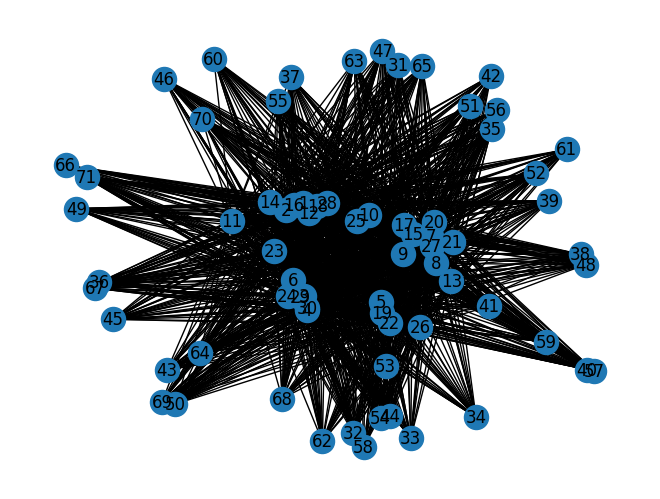

In [129]:
# instancias = [
#     "instancias/tb8ch4_0.txt",
#     "instancias/tb8ch4_1.txt",
#     "instancias/tb8ch8_0.txt",
#     "instancias/tb8ch8_1.txt",
#     "instancias/tb8ch10_0.txt",
#     "instancias/tb8ch10_1.txt",
#     "instancias/tb8ch15_0.txt",
#     "instancias/tb8ch15_1.txt",
#     "instancias/tb8ch20_0.txt",
#     "instancias/tb8ch25_0.txt",
#     "instancias/tb8ch25_1.txt",
#     "instancias/tb8ch30_0.txt",
#     "instancias/tb8ch30_1.txt"
# ]

# for instancia in instancias:
#     compara_tempos(instancia)

G, centrais = ler_instancia("instancias/tb8ch30_1.txt")
grau_minimo = 2
nx.draw(G, with_labels=True)

In [130]:
arvore,tempo = eliminacao_de_ciclos(G, centrais, grau_minimo)
print(f'Tempo para eliminação de ciclos: {tempo} ms')
if arvore is not None:
    print('Árvore geradora mínima eliminação de cliclos:')
    print(arvore)

Nenhuma solução encontrada.
Tempo para eliminação de ciclos: 0.09951257705688477 ms


Solução ótima encontrada!
Tempo para rotulação de vértices: 0.04271268844604492 ms
Árvore geradora mínima rotulacao_de_vertices:
[(1, 58), (2, 14), (3, 55), (4, 30), (5, 29), (6, 24), (7, 18), (8, 27), (9, 23), (10, 32), (11, 50), (12, 53), (13, 54), (15, 16), (17, 25), (19, 35), (20, 28), (21, 33), (22, 47), (26, 31)]


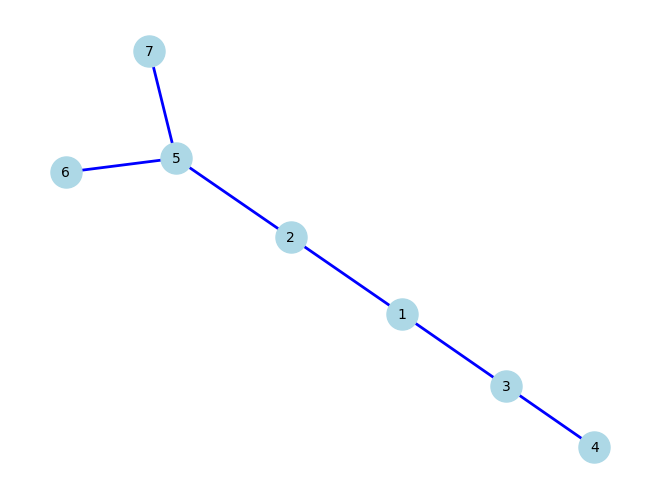

In [131]:
arvore,tempo = rotulacao_de_vertices(G, centrais, grau_minimo)
print(f'Tempo para rotulação de vértices: {tempo} ms')
if arvore is not None:
    print('Árvore geradora mínima rotulacao_de_vertices:')
    print(arvore)
    arvore_grafo = nx.Graph()
    arvore_grafo.add_edges_from([(1, 2), (1, 3), (3, 4), (2, 5), (5, 6), (5, 7)])
    pos = nx.spring_layout(arvore_grafo)
    nx.draw(arvore_grafo, pos, with_labels=True, node_color='lightblue', edge_color='blue', node_size=500, font_size=10, width=2)